## Regression Project

Build a linear regression model that predicts the `price` column in the dataset on San Francisco Apartment rentals. Make sure to go through all the the relevant steps of the modelling workflow.

A reasonable goal is to get a validation MAE of <= 500 dollars.


In [268]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

import statsmodels.api as sm
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score as r2, mean_absolute_error as mae, mean_squared_error as mse

rentals_df = pd.read_csv("sf_clean.csv")

rentals_df.head()

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
0,6800,1600.0,2.0,2.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
1,3500,550.0,1.0,1.0,(a) in-unit,(a) both,(c) multi,(b) protected,7.0
2,5100,1300.0,2.0,1.0,(a) in-unit,(a) both,(c) multi,(d) no parking,7.0
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
4,3100,561.0,1.0,1.0,(c) no laundry,(a) both,(c) multi,(d) no parking,7.0


### Data Dictionary

1. Price: The price of the rental and our target variable
2. sqft: The area in square feet of the rental
3. beds: The number of bedrooms in the rental
4. bath: The number of bathrooms in the rental
5. laundry: Does the rental have a laundry machine inside the house, a shared laundry machine, or no laundry on site?
6. pets: Does the rental allow pets? Cats only, dogs only or both cats and dogs?
7. Housing type: Is the rental in a multi-unit building, a building with two units, or a stand alone house? 
8. Parking: Does the apartment off a parking space? No, protected in a garage, off-street in a parking lot, or valet service?
9. Hood district: Which part of San Francisco is the apartment located?

<img src="SFAR_map.png" width="700"></img>

In [269]:
rentals_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 989 entries, 0 to 988
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          989 non-null    int64  
 1   sqft           989 non-null    float64
 2   beds           989 non-null    float64
 3   bath           989 non-null    float64
 4   laundry        989 non-null    object 
 5   pets           989 non-null    object 
 6   housing_type   989 non-null    object 
 7   parking        989 non-null    object 
 8   hood_district  989 non-null    float64
dtypes: float64(4), int64(1), object(4)
memory usage: 69.7+ KB


## EDA



In [270]:
rentals_df["hood_district"] = rentals_df["hood_district"].astype("object") 

In [271]:
rentals_df.describe()

,price,sqft,beds,bath
count,989.000000,989.000000,989.000000,989.000000
mean,3595.035389,976.765420,1.679474,1.390293
std,1546.222670,474.629798,1.076710,0.562714
min,750.000000,150.000000,0.000000,1.000000
25%,2650.000000,650.000000,1.000000,1.000000
50%,3300.000000,900.000000,2.000000,1.000000
75%,4242.000000,1200.000000,2.000000,2.000000
max,19000.000000,3500.000000,6.000000,4.000000


There are some very rare, expensive apartments that cost over 10k.

<Axes: xlabel='price', ylabel='Count'>

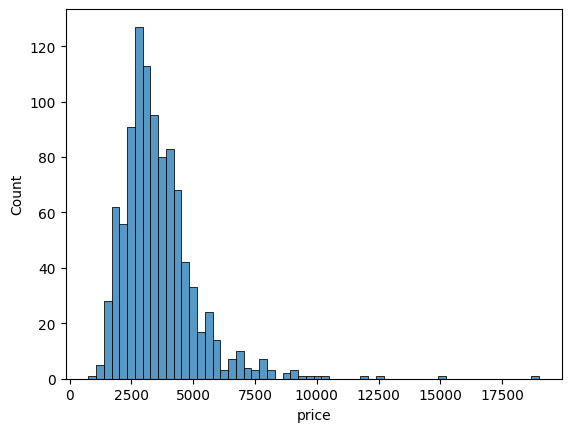

In [272]:
sns.histplot(rentals_df, x="price")

In [273]:
rentals_df[rentals_df['price'] > 10000]

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
11,15000,3500.0,4.0,3.5,(a) in-unit,(d) no pets,(a) single,(b) protected,1.0
253,19000,2358.0,3.0,3.5,(a) in-unit,(d) no pets,(c) multi,(a) valet,9.0
602,12500,2250.0,2.0,2.5,(a) in-unit,(a) both,(c) multi,(a) valet,9.0
766,10500,2179.0,3.0,3.0,(a) in-unit,(d) no pets,(c) multi,(b) protected,8.0
927,12000,3300.0,4.0,4.0,(a) in-unit,(a) both,(c) multi,(b) protected,9.0


In [274]:
rentals_df.drop(index=[253], inplace=True)

In [275]:
rentals_df[rentals_df['sqft'] > 3000]

,price,sqft,beds,bath,laundry,pets,housing_type,parking,hood_district
3,9000,3500.0,3.0,2.5,(a) in-unit,(d) no pets,(c) multi,(b) protected,7.0
11,15000,3500.0,4.0,3.5,(a) in-unit,(d) no pets,(a) single,(b) protected,1.0
409,9100,3200.0,5.0,3.0,(a) in-unit,(d) no pets,(a) single,(d) no parking,4.0
767,7995,3200.0,4.0,3.0,(a) in-unit,(a) both,(a) single,(b) protected,4.0
927,12000,3300.0,4.0,4.0,(a) in-unit,(a) both,(c) multi,(b) protected,9.0


Most of our numeric features are positively correlated with each other, could cause problems.

It's good to see that we have some strong correlations with our target here though.

<Axes: >

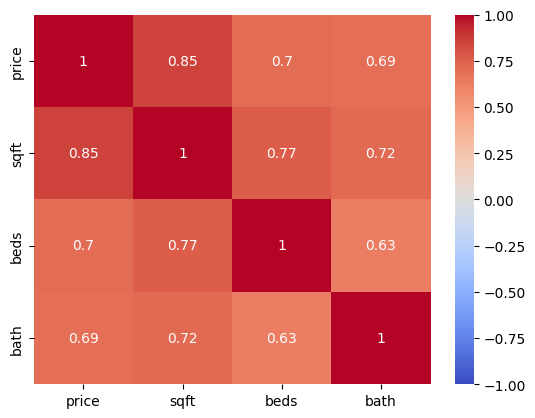

In [276]:
sns.heatmap(
    rentals_df.corr(numeric_only=True), 
    vmin=-1, 
    vmax=1, 
    cmap="coolwarm",
    annot=True
)

Based on the pairplot below, we may be able to slice off the most expensive apartments by subsetting to only apartments <2500 sq ft. 

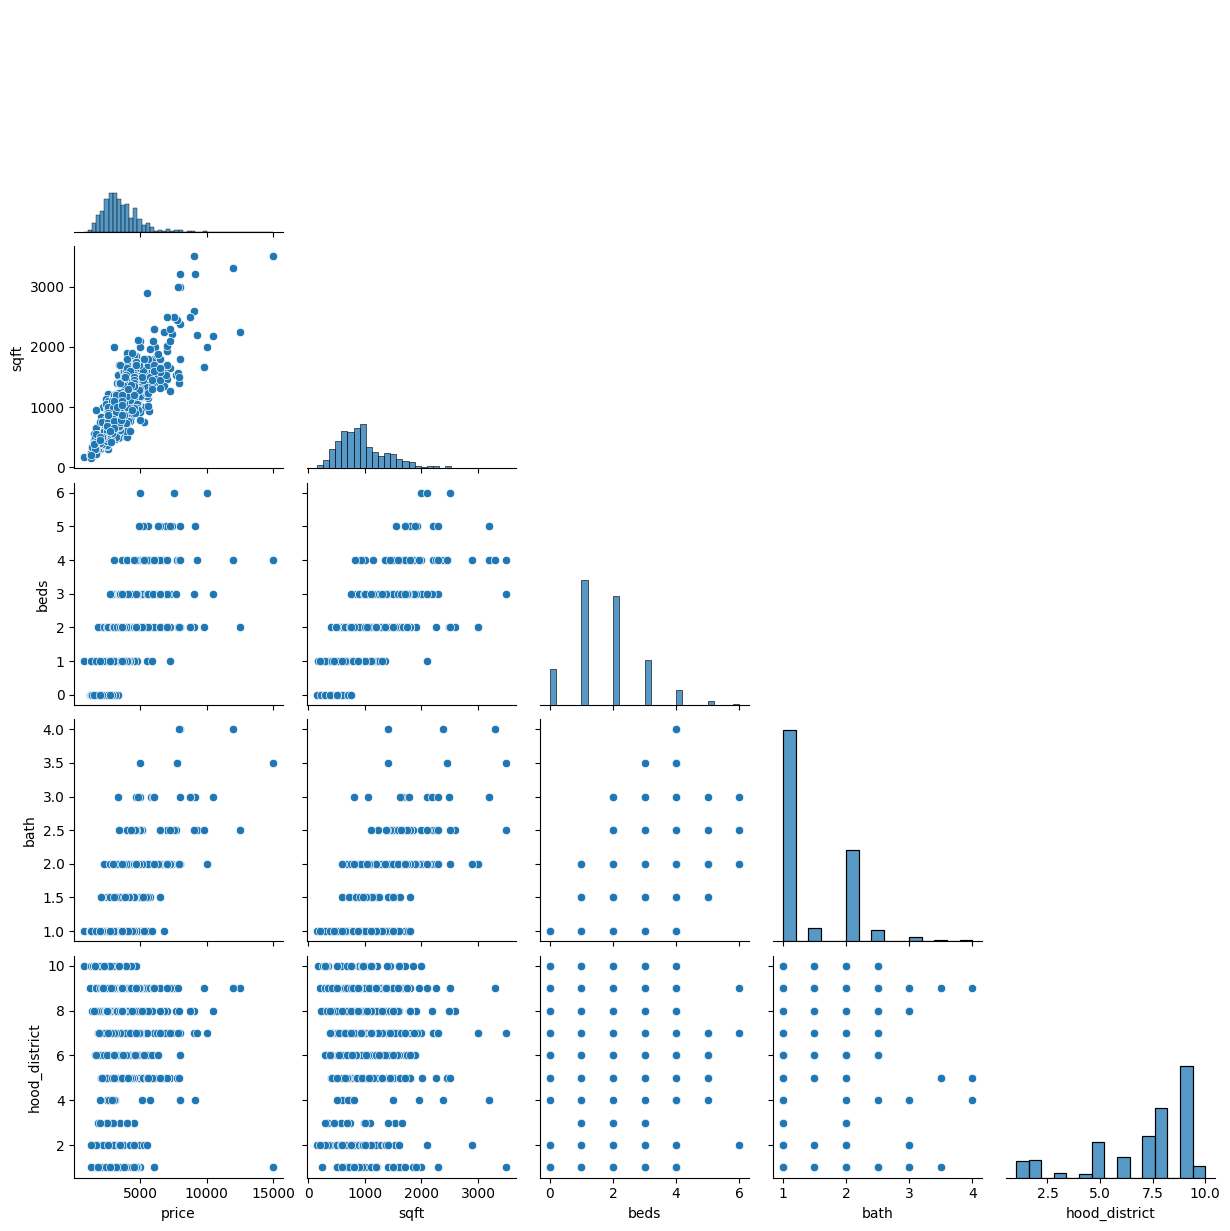

In [277]:
sns.pairplot(rentals_df, corner=True)

Moving on to our categorical features, we have some rare categories that may need to be binned together.

We should consider:

1. Pets: Bin 'dogs', and 'both' into a 'dogs' 'allows_dogs' category.
2. Housing_type: Group 'multi' and 'double' together
3. Parking: Group 'protected', 'off-street', and 'valet' together
4. We should bin some of our lower count neighbhoords with neighboring ones. Let's look at average pricing for each and see which are related based on price.

In [278]:
# Let's check the frequency of our categorical features

def value_counter(dataframe):
    value_series = pd.DataFrame()
    for col in dataframe.select_dtypes(["object"]).columns:
        print(dataframe[col].value_counts())
               
value_counter(rentals_df)

laundry
(a) in-unit       487
(b) on-site       370
(c) no laundry    131
Name: count, dtype: int64
pets
(d) no pets    509
(a) both       367
(c) cats        91
(b) dogs        21
Name: count, dtype: int64
housing_type
(c) multi     936
(a) single     40
(b) double     12
Name: count, dtype: int64
parking
(d) no parking    478
(b) protected     439
(c) off-street     38
(a) valet          33
Name: count, dtype: int64
hood_district
9.0     331
8.0     207
7.0     123
5.0     106
6.0      62
2.0      51
1.0      50
10.0     33
3.0      14
4.0      11
Name: count, dtype: int64


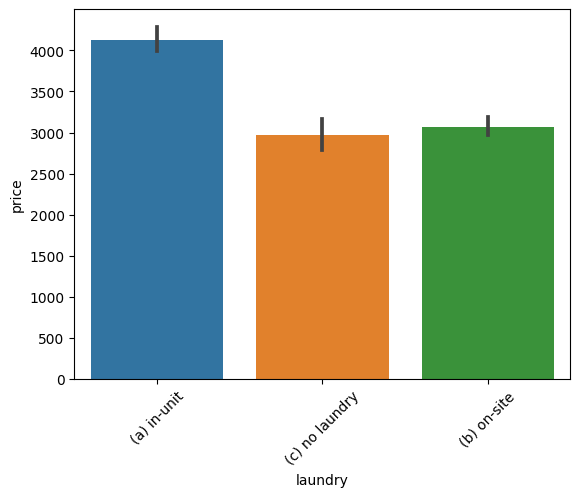

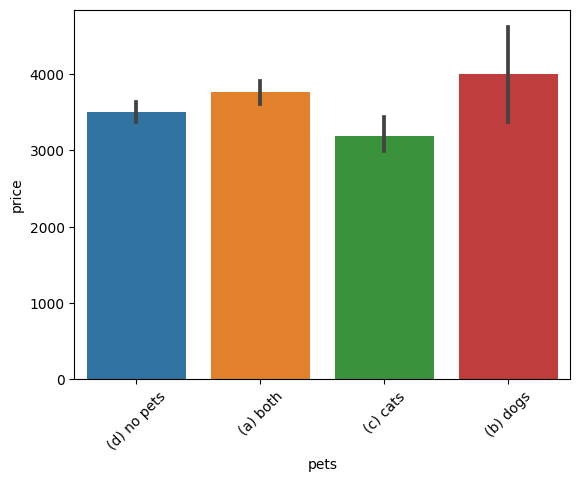

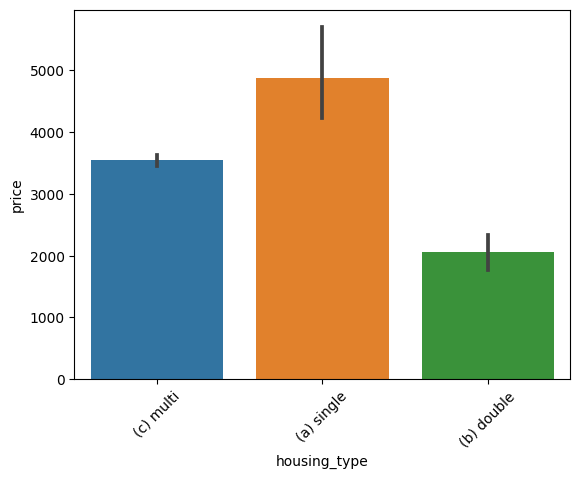

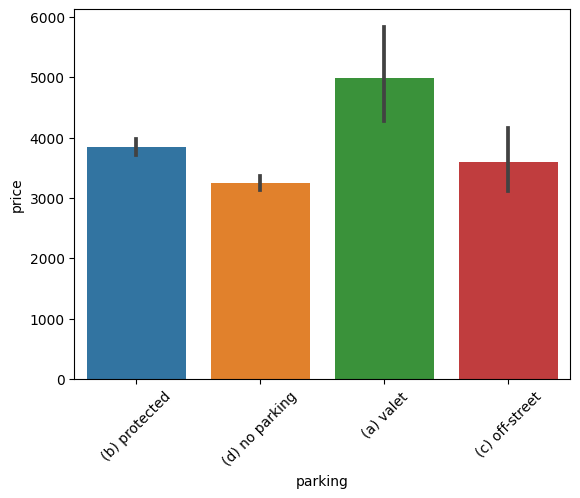

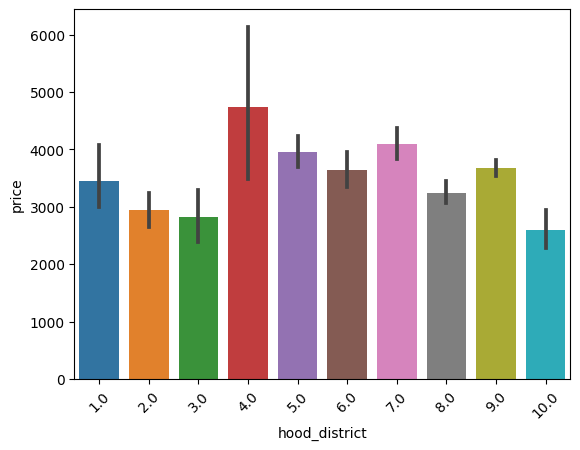

In [279]:
def cat_plotter(data, target):
    for col in data.select_dtypes(["object"]).columns:
        sns.barplot(data=data, x=col, y=target)
        plt.xticks(rotation=45)
        plt.show()
        
cat_plotter(rentals_df, "price")

<Axes: xlabel='parking', ylabel='laundry'>

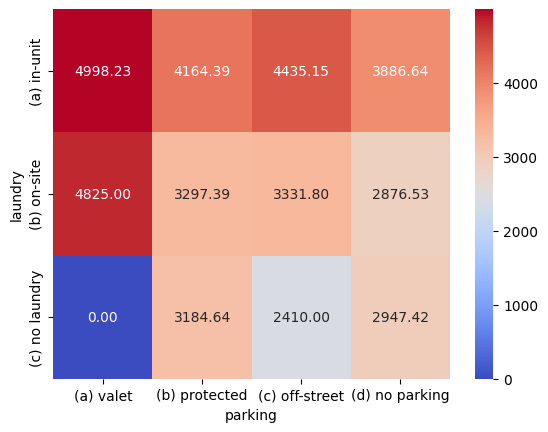

In [280]:
group = rentals_df.groupby(['laundry','parking'])['price'].mean().reset_index().pivot_table(index='laundry', columns='parking', values='price')
group.fillna(0, inplace=True)
sns.heatmap(data=group, annot=True, fmt='.2f', cmap="coolwarm")

<Axes: xlabel='parking', ylabel='housing_type'>

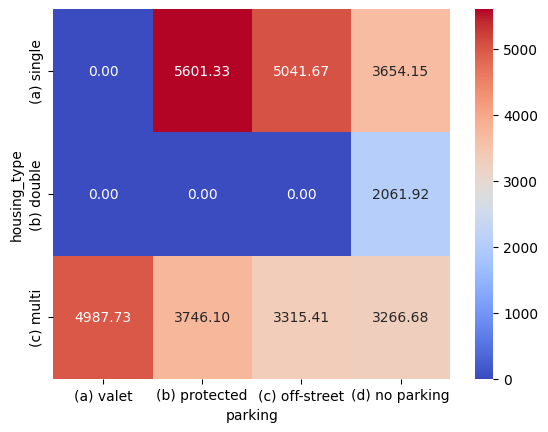

In [281]:
group = rentals_df.groupby(['housing_type','parking'])['price'].mean().reset_index().pivot_table(index='housing_type', columns='parking', values='price')
group.fillna(0, inplace=True)
sns.heatmap(data=group, annot=True, fmt='.2f', cmap="coolwarm")

# Feature Engineering

1. Group Categories together
2. Trying a Squared Term for Bedrooms, sqft, and bath

In [282]:
laundry_map = {
    "(a) in-unit": "in_unit",
    "(b) on-site": "not_in_unit",
    "(c) no laundry": "not_in_unit",
}

pet_map = {
    "(a) both": "allows_dogs",
    "(b) dogs": "allows_dogs",
    "(c) cats": "no_dogs",
    "(d) no pets": "no_dogs"
}

housing_type_map = {
    "(a) single": "single",
    "(b) double": "multi",
    "(c) multi": "multi",
}

district_map = {
    1.0: "west",
    2.0: "southwest",
    3.0: "southwest",
    4.0: "central",
    5.0: "central",
    6.0: "central",
    7.0: "marina",
    8.0: "north beach",
    9.0: "FiDi/SOMA",
    10.0: "southwest"    
}

In [283]:
eng_df = rentals_df.assign(
    hood_district = rentals_df["hood_district"].map(district_map),
    housing_type = rentals_df["housing_type"].map(housing_type_map),
    pets = rentals_df["pets"].map(pet_map),
    laundry = rentals_df["laundry"].map(laundry_map),
#     sqft2 = rentals_df["sqft"] ** 2,
#     sqft3 = rentals_df["sqft"] ** 3,
#     beds2 = rentals_df["beds"] ** 2,
#     beds3 = rentals_df["beds"] ** 3,
#     bath2 = rentals_df["bath"] ** 2,
#     bath3 = rentals_df["bath"] ** 3,
)

eng_df = pd.get_dummies(eng_df, drop_first=True)
eng_df = eng_df.astype(float)

In [284]:
eng_df.head()

,price,sqft,beds,bath,laundry_not_in_unit,pets_no_dogs,housing_type_single,parking_(b) protected,parking_(c) off-street,parking_(d) no parking,hood_district_central,hood_district_marina,hood_district_north beach,hood_district_southwest,hood_district_west
0,6800.0,1600.0,2.0,2.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,3500.0,550.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,5100.0,1300.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,9000.0,3500.0,3.0,2.5,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
4,3100.0,561.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [285]:
from sklearn.model_selection import train_test_split

target = "price"

X = sm.add_constant(eng_df.drop([target], axis=1))

# Log transform slightly improves normality
y = np.log(eng_df[target])
# y = eng_df[target]

# Test Split
X, X_test, y, y_test = train_test_split(X, y, test_size=.2, random_state=2023)

In [286]:
def cross_val(X, y, n_splits):
    
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=2023)
    # Create a list to store validation scores for each fold

    cv_lm_tr_r2s = []
    cv_lm_tr_mae = []
    cv_lm_val_r2s = []
    cv_lm_val_mae = []
    
    for train_ind, val_ind in kf.split(X, y):
        # Subset data based on CV folds
        X_train, y_train = X.iloc[train_ind], y.iloc[train_ind]
        X_val, y_val = X.iloc[val_ind], y.iloc[val_ind]
        # Fit the Model on fold's training data
        model = sm.OLS(y_train, X_train).fit()
        # Append Validation score to list 
        cv_lm_tr_r2s.append(r2(y_train, model.predict(X_train)))
        cv_lm_tr_mae.append(mae(y_train, model.predict(X_train)))
        cv_lm_val_r2s.append(r2(y_val, model.predict(X_val),))
        cv_lm_val_mae.append(mae(y_val, model.predict(X_val),))
        
        
    print(f"All Training R2s: {[round(x, 3) for x in cv_lm_tr_r2s]}")
    print(f"Training R2s: {round(np.mean(cv_lm_tr_r2s), 3)} +- {round(np.std(cv_lm_tr_r2s), 3)}")
    
    print(f"Training MAEs: {[round(x, 3) for x in cv_lm_tr_mae]}")
    print(f"Training MAEs: {round(np.mean(cv_lm_tr_mae), 3)} +- {round(np.std(cv_lm_tr_mae), 3)}")    
        
    print(f"All Validation R2s: {[round(x, 3) for x in cv_lm_val_r2s]}")
    print(f"Cross Val R2s: {round(np.mean(cv_lm_val_r2s), 3)} +- {round(np.std(cv_lm_val_r2s), 3)}")

    print(f"All Validation MAEs: {[round(x, 3) for x in cv_lm_val_mae]}")
    print(f"Cross Val MAEs: {round(np.mean(cv_lm_val_mae), 3)} +- {round(np.std(cv_lm_val_mae), 3)}")
    
    return model
    
model = cross_val(X, y, 5)

All Training R2s: [0.808, 0.809, 0.818, 0.809, 0.802]
Training R2s: 0.809 +- 0.005
Training MAEs: [0.128, 0.129, 0.128, 0.129, 0.128]
Training MAEs: 0.128 +- 0.0
All Validation R2s: [0.797, 0.8, 0.751, 0.8, 0.819]
Cross Val R2s: 0.793 +- 0.023
All Validation MAEs: [0.134, 0.129, 0.135, 0.129, 0.132]
Cross Val MAEs: 0.132 +- 0.003


In [287]:
# Model p-values: a few features have > .05

model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.802
Model:                            OLS   Adj. R-squared:                  0.798
Method:                 Least Squares   F-statistic:                     179.0
Date:                Mon, 22 Jan 2024   Prob (F-statistic):          1.79e-206
Time:                        17:03:48   Log-Likelihood:                 247.60
No. Observations:                 632   AIC:                            -465.2
Df Residuals:                     617   BIC:                            -398.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.7716      0.042    186.654      0.000       7.690       7.853
sqft                          0.0004    2.6e-05     14.849      0.000       0.000       0.000
beds                          0.1133      0.010     11.046      0.000       0.093       0.133
bath                          0.0193      0.018      1.079      0.281      -0.016       0.054
laundry_not_in_unit          -0.0853      0.016     -5.465      0.000      -0.116      -0.055
pets_no_dogs                 -0.0392      0.014     -2.747      0.006      -0.067      -0.011
housing_type_single          -0.0476      0.037     -1.302      0.193      -0.119       0.024
parking_(b) protected        -0.1516      0.036     -4.200      0.000      -0.223      -0.081
parking_(c) off-street       -0.1516      0.050     -3.004      0.003      -0.251      -0.052
parking_(d) no parking       -0.2378      0.037     -6.377      0.000      -0.311      -0.165
hood_district_central         0.0406      0.020      2.052      0.041       0.002       0.080
hood_district_marina          0.1210      0.023      5.181      0.000       0.075       0.167
hood_district_north beach     0.0156      0.020      0.799      0.425      -0.023       0.054
hood_district_southwest      -0.1400      0.027     -5.114      0.000      -0.194      -0.086
hood_district_west           -0.0512      0.031     -1.654      0.099      -0.112       0.010
==============================================================================
Omnibus:                        6.241   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                7.991
Skew:                           0.084   Prob(JB):                       0.0184
Kurtosis:                       3.524   Cond. No.                     1.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

1. Linearity - no obvious curvature
2. Independence - DW Test Statistic Looks Good!
3. Normality - Slighly off before log transform, much better afterwards... may not be worth interpretability
4. No Perfect MultiCollinearity - VIFs look OK
5. Equal Variance - slight heteroskedasticity prior to log transform

In [288]:
def residual_analysis_plots(model):
    
    import scipy.stats as stats
    import matplotlib.pyplot as plt
    
    predictions = model.predict()
    residuals = model.resid
    
    fig, ax = plt.subplots(1, 2, sharey="all", figsize=(10, 6))
    
    sns.scatterplot(x=predictions, y=residuals, ax=ax[0])
    ax[0].set_title("Residual Plot")
    ax[0].set_xlabel("Prediction")
    ax[0].set_ylabel("Residuals")
    
    stats.probplot(residuals, dist="norm", plot=ax[1])
    ax[1].set_title("Normal Q-Q Plot")   

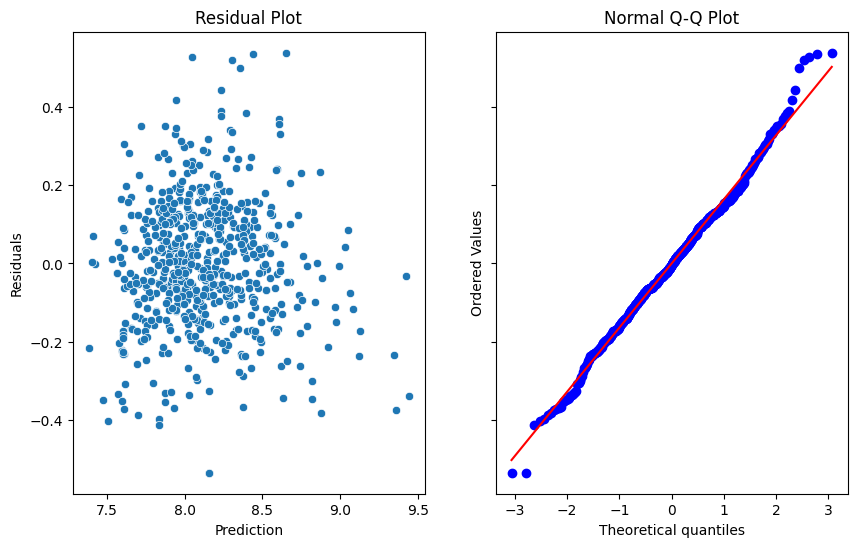

In [289]:
residual_analysis_plots(model)

In [290]:
# VIF Looks OK -- our parking dummy features are a bit high but no major concern

from statsmodels.stats.outliers_influence import variance_inflation_factor as vif

pd.Series(
    [vif(X.values, i) for i in range(X.shape[1])],
    index=X.columns
)

const                        40.196162
sqft                          3.459471
beds                          2.731549
bath                          2.293173
laundry_not_in_unit           1.405059
pets_no_dogs                  1.114389
housing_type_single           1.178017
parking_(b) protected         7.414573
parking_(c) off-street        2.195605
parking_(d) no parking        7.985691
hood_district_central         1.401397
hood_district_marina          1.368934
hood_district_north beach     1.443173
hood_district_southwest       1.373756
hood_district_west            1.214952
dtype: float64

In [291]:
influence = model.get_influence()
inf_summary_df = influence.summary_frame()
inf_summary_df["cooks_d"].sort_values(ascending=False).head()


863    0.038926
3      0.032264
767    0.032158
585    0.029046
465    0.024234
Name: cooks_d, dtype: float64

## Final Model Fit

In [292]:
final_model = sm.OLS(y, X).fit()

final_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.808
Model:                            OLS   Adj. R-squared:                  0.805
Method:                 Least Squares   F-statistic:                     233.4
Date:                Mon, 22 Jan 2024   Prob (F-statistic):          1.55e-266
Time:                        17:03:50   Log-Likelihood:                 302.60
No. Observations:                 790   AIC:                            -575.2
Df Residuals:                     775   BIC:                            -505.1
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         7.7781      0.038    207.025      0.000       7.704       7.852
sqft                          0.0004   2.32e-05     16.527      0.000       0.000       0.000
beds                          0.1103      0.009     12.197      0.000       0.093       0.128
bath                          0.0272      0.016      1.714      0.087      -0.004       0.058
laundry_not_in_unit          -0.0849      0.014     -6.043      0.000      -0.113      -0.057
pets_no_dogs                 -0.0312      0.013     -2.444      0.015      -0.056      -0.006
housing_type_single          -0.0249      0.033     -0.750      0.453      -0.090       0.040
parking_(b) protected        -0.1709      0.033     -5.255      0.000      -0.235      -0.107
parking_(c) off-street       -0.1761      0.045     -3.953      0.000      -0.264      -0.089
parking_(d) no parking       -0.2524      0.034     -7.532      0.000      -0.318      -0.187
hood_district_central         0.0420      0.018      2.304      0.021       0.006       0.078
hood_district_marina          0.1041      0.021      4.883      0.000       0.062       0.146
hood_district_north beach     0.0049      0.017      0.284      0.776      -0.029       0.039
hood_district_southwest      -0.1626      0.024     -6.902      0.000      -0.209      -0.116
hood_district_west           -0.0413      0.029     -1.434      0.152      -0.098       0.015
==============================================================================
Omnibus:                       18.064   Durbin-Watson:                   1.961
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               36.073
Skew:                          -0.012   Prob(JB):                     1.47e-08
Kurtosis:                       4.047   Cond. No.                     1.23e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.23e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [293]:
print(mae(np.exp(y_test), np.exp(final_model.predict(X_test)))) 
# print(f"Test MAE: {mae(y_test, model.predict(X_test))}") #468.13 if not transformed
print(f"Test R2: {r2(y_test, final_model.predict(X_test))}")

474.51299802546663
Test R2: 0.7840327580261137


##### Project developed in the Udemy course "Data science in python: Regression and Forecasting"